In [1]:
import pandas as pd

df = pd.read_csv('../data/augmented_population.csv', index_col=0)
df

FileNotFoundError: [Errno 2] No such file or directory: 'data/augmented_population.csv'

In [2]:
houses_pop = 8100
tents_block1 = (len(df) - houses_pop) / 4 * 0.5
tents_block2 = (len(df) - houses_pop) / 4 * 0.3
tents_block3 = (len(df) - houses_pop) / 4 * 0.2

In [3]:
dims_isoboxes = (29, 28)  # 812
dims_block1 = (20, 67)  # 1340
dims_block2 = (53, 15)  # 795
dims_block3 = (19, 28)  # 532

In [4]:
from network_utils import *

grid_isoboxes = create_grid(dims_isoboxes[0], dims_isoboxes[1], 0)
grid_block1 = create_grid(dims_block1[0], dims_block1[1], grid_isoboxes[-1][-1] + 1)
grid_block2 = create_grid(dims_block2[0], dims_block2[1], grid_block1[-1][-1] + 1)
grid_block3 = create_grid(dims_block3[0], dims_block3[1], grid_block2[-1][-1] + 1)

In [5]:
from scipy.stats import poisson

isobox_mean = 10
tent_mean = 4

max_pop_per_struct = list(poisson.rvs(mu=isobox_mean, size=dims_isoboxes[0]*dims_isoboxes[1]))
max_pop_per_struct = max_pop_per_struct + list(poisson.rvs(mu=tent_mean, size=dims_block1[0]*dims_block1[1]))
max_pop_per_struct = max_pop_per_struct + list(poisson.rvs(mu=tent_mean, size=dims_block2[0]*dims_block2[1]))
max_pop_per_struct = max_pop_per_struct + list(poisson.rvs(mu=tent_mean, size=dims_block3[0]*dims_block3[1]))

In [6]:
from stats_utils import *

n_pop = 18700
n_structs = len(max_pop_per_struct)

# Isoboxes
n_isoboxes = 812
pop_isoboxes = 8100
pop_per_isobox = 10

# Tents
n_tents = 2650
pop_tents = 10600
pop_per_tent = 4

# Others 
n_bathrooms = 144
n_ethnic_groups = 8

# Isobox grid parameters - can be extended to tents as well
grid_width = 29
grid_height = 28

# We define neighboring isoboxes as any isobox within a range of 2 in the isobox grid
iso_proximity = 2

# Sample the population age, and parameter rates
sample_pop = sample_population(n_pop, 'data/augmented_population.csv')

In [8]:
household_weight = 0.98  # Edge weight for connections within each isobox
graph, nodes_per_struct = create_graph(n_structs, 0, n_pop, max_pop_per_struct, 
                                       edge_weight=household_weight, label="household",
                                       age_list=list(sample_pop["age"]),
                                       sex_list = list(sample_pop["sex"]),
                                       n_ethnicities=n_ethnic_groups)

100%|██████████| 18700/18700 [00:17<00:00, 1056.78it/s]


In [11]:
neighbor_weight = 0.017
graph = connect_neighbors(graph, 0, n_isoboxes, nodes_per_struct,
                          grid_isoboxes, 2, neighbor_weight, 'friendship')
graph = connect_neighbors(graph, dims_isoboxes[0]*dims_isoboxes[1], dims_block1[0]*dims_block1[1], nodes_per_struct,
                          grid_block1, 2, neighbor_weight, 'friendship')
graph = connect_neighbors(graph, dims_block1[0]*dims_block1[1], dims_block2[0]*dims_block2[1], nodes_per_struct,
                          grid_block2, 2, neighbor_weight, 'friendship')
graph = connect_neighbors(graph, dims_block2[0]*dims_block2[1], dims_block3[0]*dims_block3[1], nodes_per_struct,
                          grid_block3, 2, neighbor_weight, 'friendship')

In [25]:
graph.nodes[nodes_per_struct[813][0]], nodes_per_struct[813][0]

({'age': 41.7, 'sex': 0, 'location': 813, 'ethnicity': 7}, 3009)

In [26]:
connected_bois = [edge[1] for edge in graph.edges if edge[0] == 3009]
[graph.nodes[cb] for cb in connected_bois]

[{'age': 12.8, 'sex': 0, 'location': 813, 'ethnicity': 1},
 {'age': 32.9, 'sex': 1, 'location': 813, 'ethnicity': 4},
 {'age': 0.1, 'sex': 0, 'location': 813, 'ethnicity': 0},
 {'age': 25.9, 'sex': 1, 'location': 1558, 'ethnicity': 7},
 {'age': 12.0, 'sex': 0, 'location': 1559, 'ethnicity': 7},
 {'age': 23.0, 'sex': 1, 'location': 1690, 'ethnicity': 7},
 {'age': 49.1, 'sex': 0, 'location': 1690, 'ethnicity': 7},
 {'age': 26.5, 'sex': 1, 'location': 1690, 'ethnicity': 7},
 {'age': 6.8, 'sex': 0, 'location': 1691, 'ethnicity': 7},
 {'age': 4.2, 'sex': 0, 'location': 1693, 'ethnicity': 7},
 {'age': 0.0, 'sex': 1, 'location': 1492, 'ethnicity': 7},
 {'age': 18.7, 'sex': 1, 'location': 1623, 'ethnicity': 7},
 {'age': 39.2, 'sex': 1, 'location': 1757, 'ethnicity': 7},
 {'age': 49.7, 'sex': 0, 'location': 3452, 'ethnicity': 7},
 {'age': 34.0, 'sex': 0, 'location': 3453, 'ethnicity': 7},
 {'age': 12.0, 'sex': 0, 'location': 3453, 'ethnicity': 7},
 {'age': 22.9, 'sex': 0, 'location': 3454, 'eth

In [22]:
len(nodes_per_struct)

3479

In [29]:
for i in range(dims_block2[0]*dims_block2[1], dims_block2[0]*dims_block2[1] + dims_block3[0]*dims_block3[1]):
    connected_bois = [edge[1] for edge in graph.edges if edge[0] == nodes_per_struct[i][0]]
    
    if len(connected_bois) > 4:
        print([graph.nodes[cb] for cb in connected_bois])
        break

[{'age': 21.7, 'sex': 1, 'location': 795, 'ethnicity': 1}, {'age': 22.7, 'sex': 1, 'location': 795, 'ethnicity': 7}, {'age': 1.1, 'sex': 0, 'location': 795, 'ethnicity': 2}, {'age': 2.3, 'sex': 1, 'location': 795, 'ethnicity': 3}, {'age': 34.8, 'sex': 0, 'location': 795, 'ethnicity': 0}, {'age': 30.7, 'sex': 1, 'location': 795, 'ethnicity': 0}, {'age': 24.0, 'sex': 1, 'location': 795, 'ethnicity': 5}, {'age': 35.1, 'sex': 1, 'location': 795, 'ethnicity': 1}, {'age': 20.9, 'sex': 1, 'location': 795, 'ethnicity': 3}, {'age': 30.1, 'sex': 1, 'location': 737, 'ethnicity': 0}, {'age': 41.6, 'sex': 0, 'location': 739, 'ethnicity': 0}, {'age': 31.6, 'sex': 0, 'location': 739, 'ethnicity': 0}, {'age': 31.7, 'sex': 0, 'location': 741, 'ethnicity': 0}, {'age': 26.3, 'sex': 1, 'location': 741, 'ethnicity': 0}, {'age': 2.6, 'sex': 0, 'location': 741, 'ethnicity': 0}, {'age': 8.0, 'sex': 1, 'location': 741, 'ethnicity': 0}, {'age': 40.0, 'sex': 0, 'location': 765, 'ethnicity': 0}, {'age': 1.0, 'sex

In [30]:
food_weight = 0.407  # Edge weight for connections in the food queue 
graph = connect_food_queue(graph, nodes_per_struct, food_weight, "food") 

In [36]:
from seirsplus.models import *

beta = 1.28
sigma = 1/5.1
gamma = 0.056
initI = 10

ref_model = SEIRSNetworkModel(G=graph, beta=beta, sigma=sigma, gamma=gamma, mu_I=list(sample_pop["death_rate"]), p=0.5,
                              beta_D=beta, sigma_D=sigma, gamma_D=gamma, mu_D=list(sample_pop["death_rate"]),
                              theta_E=0, theta_I=0, phi_E=0, phi_I=0, psi_E=1.0, psi_I=1.0, q=0.5,
                              initI=10)

ref_model.run(T=300)

t = 0.04
t = 10.00
t = 20.00
t = 30.00
t = 40.00
t = 50.00
t = 60.00
t = 70.00
t = 80.00
t = 90.28
t = 100.05
t = 110.09
t = 120.09
t = 130.05
t = 150.25
t = 170.79


True

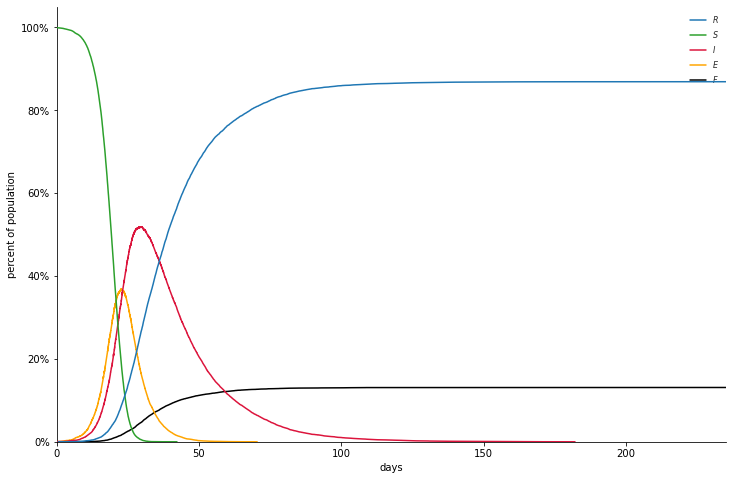

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa13f87d650>)

In [37]:
ref_model.figure_basic()